## Experimenting with graphframe and pyspark

I tend to follow the User guide for Graphframe and that is posted on Databricks https://docs.databricks.com/spark/latest/graph-analysis/graphframes/user-guide-python.html. 

First, we will import the packages needed to construct the graph data structure in the Graphframe.

In [1]:
# Import PySpark and Graphframe
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField
from graphframes import *
import matplotlib.pyplot as plt

Now, read the fork edges and the contribution edges from the text file `fork_edges.txt` and `contrib_edges.txt`. For each line in the two files, the edges will be in the form of a tuple `(u,r)` or `(r,u)`. Here `r` and `u` specifies the repositories ID and user ID on GitHub. For more information about the storage formats of `fork_edges.txt` and `contrib_edges.txt`. and how edges are collected (and how the network is formed), please consult the meta file `meta.md`. 

In [19]:
from parse_edges import parse_edges

# Parse string literal to become list of tuples
contrib_edges, fork_edges = (parse_edges('contrib_edges.txt', 'c'),
                             parse_edges('fork_edges.txt', 'f'))

edges = contrib_edges + fork_edges
vertices = [(v,) for v in set([l for e in edges for l in e])]

After we read in the contribution edges and fork edges, we will build the Biparitite Graph using Graphframe. First, we will construct two data frames: `vertices` and `edges`. Using these two tables, we will construct a graph structure in Spark. 

In [20]:
# Create a Spark Session for Dataframe and SQL functionality
#GHnet = SparkSession \
#    .builder \
#    .appName("GHnet") \
#    .getOrCreate()

# Construct the two tables from list of edges and user IDs
vertices_table = GHnet.createDataFrame(vertices, ['id'])
edges_table = GHnet.createDataFrame(edges, ['src', 'dst'])

# Create a graphframe object
GHnet_graphframe = GraphFrame(vertices_table, edges_table)

## Preliminary EDA on the Graph
After we create a graphframe object, we can now do some preliminary EDA on the graph. One straightfoward thing we can check is the in and out degree distribution of the users and repos. 

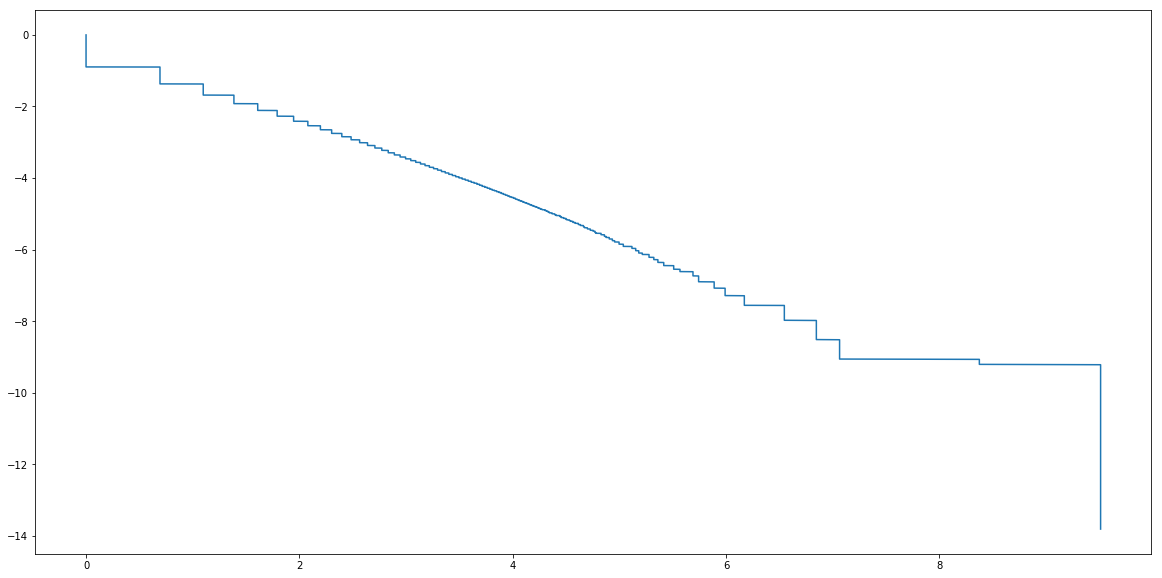

In [28]:
#num_of_forks = GHnet_graphframe.outDegrees.filter("id < 0").cache()
#print(num_of_forks.stat.approxQuantile(col='outDegree', probabilities=(0.9999999,), relativeError=1e-6))
#import numpy as np

#num_of_contribs = GHnet_graphframe.inDegrees.filter("id < 0").cache()
samp_probs = np.linspace(0, 1, int(1e6)).tolist()
plt.figure(figsize=(20,10))
plt.plot(np.log(num_of_forks.stat.approxQuantile(col='outDegree',
                                            probabilities=samp_probs,
                                            relativeError=1e-4)),
        np.log([1-i for i in samp_probs]), )
#num_of_forks.stat.approxQuantile(col='outDegree',
#                                 probabilities=(.90,),
#                                 relativeError=1e-4)

In [40]:
a = 'f'
title = 'Fork Degree dist' if a == 'f' \
else "Contrib Degree dist"
title

'Fork Degree dist'

## Page Rank of GitHub's repository and users
Top ten influential repository?

## Graph Spectrum
Since we don't have the direct collaboration information between users (which requires push access to specific repo), we are only able to collect the contributors of specific repos and users who fork the repos. Thus the contribution-fork edge network is bipartite.

Let $A$  be the Adjacency matrix of GitHub's contribution-fork network and assume there are $m$ repos and $n$ users. $A_{ur}$ be the adjacency matrix that represents contribution edges, and $A_{ru}$ be the adjacency matrix that represents the fork edges. Then $A$ can be written in block matrix form $$A = \begin{pmatrix} 0_n & A_{ur}\\ A_{ru}& 0_m\end{pmatrix}$$. Thus the matrix $A$ is singular, thus having 0 eigenvalue. 

## Community Detection
Implement community detection algorithms

# (If Time allows) Matrix completion problem
We now observe a bipartite contribution-fork network. But we know that users on GitHub collaborate with each other (or they can follow someone they look up to) and repos depends on other repos as well (unless developers enjoy torturing themselves or tired of being tortured by shitty packages they use on a daily basis). We can think of this as a matrix completion problem, where we want to fill in the unobserved entries in our population adjacency matrix. Suppose we have a small sample of collaboration/follower and repository dependency information, can we use that to complete our population graph?